# NEU 437 Wong et al.

References :

1. A Recurrent Network Mechanism of Time Integration in Perceptual Decisions Kong-Fatt Wong, Xiao-Jing Wang Journal of Neuroscience 25 January 2006, 26 (4) 1314-1328
2. Justin Bois (2017). "Some dynamical systems approaches" [http://be150.caltech.edu/2017/handouts/dynamical_systems_approaches.html] (MIT License)
3. https://github.com/sukhbinder/intersection (MIT License)
4. https://matplotlib.org/3.1.1/gallery/widgets/slider_demo.html

Plotting of the dynamics follow [2] with heavy modifications. Finding the fixed points is done with the intersection function of [3].

In [3]:
# Math
import numpy as np
import scipy.integrate
import scipy.optimize

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

System to be solved (Appendix A in paper) :

<img src="equations.PNG" alt="Drawing" style="width: 400px;"/>

with values :

In [35]:
a = 270 # (VnC)^-1
b = 108 # Hz
d = 0.154 # s
gamma = 0.641 # (unitless)
tau_s = 100E-3 # s
w = 1.59 # base value
J_N11 = 0.2609 # nA ADDED W HERE TO SIMULATE INCREASED SELF-ACTIVITY
J_N22 = J_N11
J_N12 = 0.0497 # nA
J_N21 = J_N12
J_Aext = 5.2E-4 # nA/Hz
I0 = 0.3255 # nA
mu0 = 30 # 30 # Hz
c = 0

The mean firing rates of the two decision clusters are monotonically linked to the ODE variables via 

<img src="equations_3.PNG" alt="Drawing" style="width: 100px;"/>

or more precisely (Supp. Info) :

<img src="equations_2.PNG" alt="Drawing" style="width: 400px;"/>

In [36]:
def I1(J_Aext, mu0, c):
    "Input current 1"
    return J_Aext*mu0*(1 + c/100)

def I2(J_Aext, mu0, c):
    "Input current 2"
    return J_Aext*mu0*(1 - c/100)

def x(Jnn, Sn, Jnm, Sm, I0, In):
    "Change-of-variables"
    return Jnn*Sn - Jnm*Sm + I0 + In

def H(a, b, x):
    """Transfer function"""
    return (a*x-b)/(1 - np.exp(-d*(a*x-b)))

def toggle(variables, t, tau_s, gamma, a, b, J_N11, J_N12, J_N21, J_N22, I0, J_Aext, mu0, c):
    """Right hand side for toggle ODEs."""
    S1, S2 = variables
    x1 = x(J_N11, S1, J_N12, S2, I0, I1(J_Aext, mu0, c))
    x2 = x(J_N22, S2, J_N21, S1, I0, I2(J_Aext, mu0, c))
    return np.array([-S1/tau_s + (1-S1)*gamma*H(a, b, x1),
                     -S2/tau_s + (1-S2)*gamma*H(a, b, x2) ])

Also : inspired by diagram, incorporate $w_+$ as a multiplicative factor for self-excitation $w_+/1.59\times J_Nii$.

In [37]:
%matplotlib inline

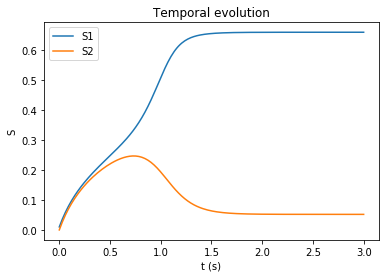

In [40]:
args = (tau_s, gamma, a, b, w/1.59*J_N11, J_N12, J_N21, w/1.59*J_N22, I0, J_Aext, mu0, c)

# Initial condition
ab0 = np.array([0.01, 0])

# Solve
t = np.linspace(0, 3,200)
variables = scipy.integrate.odeint(toggle, ab0, t, args=args)

# Plot
plt.plot(t, variables)
plt.xlabel('t (s)')
plt.ylabel('S')
plt.legend(('S1', 'S2'));
plt.title("Temporal evolution")
plt.show()

In [41]:
def plot_flow_field(ax, f, u_range, v_range, args=(), n_grid=100):
    """
    Plots the flow field with line thickness proportional to speed.
    
    Parameters
    ----------
    ax : Matplotlib Axis instance
        Axis on which to make the plot
    f : function for form f(y, t, *args)
        The right-hand-side of the dynamical system.
        Must return a 2-array.
    u_range : array_like, shape (2,)
        Range of values for u-axis.
    v_range : array_like, shape (2,)
        Range of values for v-axis.
    args : tuple, default ()
        Additional arguments to be passed to f
    n_grid : int, default 100
        Number of grid points to use in computing
        derivatives on phase portrait.
        
    Returns
    -------
    output : Matplotlib Axis instance
        Axis with streamplot included.
    """
        
    # Set up u,v space
    u = np.linspace(u_range[0], u_range[1], n_grid)
    v = np.linspace(v_range[0], v_range[1], n_grid)
    uu, vv = np.meshgrid(u, v)

    # Compute derivatives
    u_vel = np.empty_like(uu)
    v_vel = np.empty_like(vv)
    for i in range(uu.shape[0]):
        for j in range(uu.shape[1]):
            u_vel[i,j], v_vel[i,j] = f(np.array([uu[i,j], vv[i,j]]), None, *args)

    # Compute speed
    speed = np.sqrt(u_vel**2 + v_vel**2)

    # Make linewidths proportional to speed,
    # with minimal line width of 0.5 and max of 3
    lw = 0.5 + 2.5 * speed / speed.max()

    # Make stream plot
    ax.streamplot(uu, vv, u_vel, v_vel, linewidth=lw, arrowsize=1.2, 
                  density=1, color='thistle')

    return ax

In [42]:
def _rect_inter_inner(x1,x2):
    n1=x1.shape[0]-1
    n2=x2.shape[0]-1
    X1=np.c_[x1[:-1],x1[1:]]
    X2=np.c_[x2[:-1],x2[1:]]
    S1=np.tile(X1.min(axis=1),(n2,1)).T
    S2=np.tile(X2.max(axis=1),(n1,1))
    S3=np.tile(X1.max(axis=1),(n2,1)).T
    S4=np.tile(X2.min(axis=1),(n1,1))
    return S1,S2,S3,S4

def _rectangle_intersection_(x1,y1,x2,y2):
    S1,S2,S3,S4=_rect_inter_inner(x1,x2)
    S5,S6,S7,S8=_rect_inter_inner(y1,y2)

    C1=np.less_equal(S1,S2)
    C2=np.greater_equal(S3,S4)
    C3=np.less_equal(S5,S6)
    C4=np.greater_equal(S7,S8)

    ii,jj=np.nonzero(C1 & C2 & C3 & C4)
    return ii,jj

def intersection(x1,y1,x2,y2):
    """
INTERSECTIONS Intersections of curves.
   Computes the (x,y) locations where two curves intersect.  The curves
   can be broken with NaNs or have vertical segments.
usage:
x,y=intersection(x1,y1,x2,y2)
    Example:
    a, b = 1, 2
    phi = np.linspace(3, 10, 100)
    x1 = a*phi - b*np.sin(phi)
    y1 = a - b*np.cos(phi)
    x2=phi
    y2=np.sin(phi)+2
    x,y=intersection(x1,y1,x2,y2)
    plt.plot(x1,y1,c='r')
    plt.plot(x2,y2,c='g')
    plt.plot(x,y,'*k')
    plt.show()
    """
    ii,jj=_rectangle_intersection_(x1,y1,x2,y2)
    n=len(ii)

    dxy1=np.diff(np.c_[x1,y1],axis=0)
    dxy2=np.diff(np.c_[x2,y2],axis=0)

    T=np.zeros((4,n))
    AA=np.zeros((4,4,n))
    AA[0:2,2,:]=-1
    AA[2:4,3,:]=-1
    AA[0::2,0,:]=dxy1[ii,:].T
    AA[1::2,1,:]=dxy2[jj,:].T

    BB=np.zeros((4,n))
    BB[0,:]=-x1[ii].ravel()
    BB[1,:]=-x2[jj].ravel()
    BB[2,:]=-y1[ii].ravel()
    BB[3,:]=-y2[jj].ravel()

    for i in range(n):
        try:
            T[:,i]=np.linalg.solve(AA[:,:,i],BB[:,i])
        except:
            T[:,i]=np.NaN


    in_range= (T[0,:] >=0) & (T[1,:] >=0) & (T[0,:] <=1) & (T[1,:] <=1)

    xy0=T[2:,in_range]
    xy0=xy0.T
    return xy0[:,0],xy0[:,1]

def plot_null_clines_toggle(ax, S1_range, S2_range, args, 
                            colors=['#1f77b4', '#1f77b4'], lw=3):
    """Add nullclines to ax."""
        
    (X,Y) = np.meshgrid(np.linspace(S1_range[0], S1_range[1], 100),
                        np.linspace(S2_range[0], S2_range[1], 100) )
    tau_s, gamma, a, b, J_N11, J_N12, J_N21, J_N22, I0, J_Aext, mu0, c = args
    
    x1 = x(J_N11, X, J_N12, Y, I0, I1(J_Aext, mu0, c))
    nullcline_S1 = -X/tau_s + (1-X)*gamma*H(a, b, x1)
    
    x2 = x(J_N22, Y, J_N21, X, I0, I2(J_Aext, mu0, c))
    nullcline_S2 = -Y/tau_s + (1-Y)*gamma*H(a, b, x2)

    # Plot nullcline S1
    cs = ax.contour(X, Y, nullcline_S1, 0, lw=lw, color=colors[0])
    # Report nullcline S1
    p = cs.collections[1].get_paths()[0]
    v = p.vertices
    nullcline_S1_S1 = v[:,0]
    nullcline_S1_S2 = v[:,1]
    
    # Plot nullcline S2
    cs = ax.contour(X, Y, nullcline_S2, 0, lw=lw, color=colors[1])
    # Report nullcline S2
    p = cs.collections[1].get_paths()[0]
    v = p.vertices
    nullcline_S2_S1 = v[:,0]
    nullcline_S2_S2 = v[:,1] 
    
    # Find fixed points
    fp_S1, fp_S2 = intersection(nullcline_S1_S1, nullcline_S1_S2,
                              nullcline_S2_S1, nullcline_S2_S2)
    ax.plot(fp_S1, fp_S2, "o", markersize=6, markeredgecolor='k', markerfacecolor='k')
    
    return ax

In [43]:
def plot_traj(ax, f, y0, t, S1_range, S2_range, args=(), color='black', lw=2):
    """
    Plots a trajectory on a phase portrait.
    
    Parameters
    ----------
    ax : Matplotlib Axis instance
        Axis on which to make the plot
    f : function for form f(y, t, *args)
        The right-hand-side of the dynamical system.
        Must return a 2-array.
    y0 : array_like, shape (2,)
        Initial condition.
    t : array_like
        Time points for trajectory.
    args : tuple, default ()
        Additional arguments to be passed to f
    n_grid : int, default 100
        Number of grid points to use in computing
        derivatives on phase portrait.
        
    Returns
    -------
    output : Matplotlib Axis instance
        Axis with streamplot included.
    """
    
    y = scipy.integrate.odeint(f, y0, t, args=args)
    ax.plot(*y.transpose(), color=color, lw=lw)
    ax.set_xlim(S1_range)
    ax.set_ylim(S2_range)
    return ax

# Interactivity

In [46]:
%matplotlib widget

In [60]:
%matplotlib widget
import warnings
warnings.filterwarnings('ignore')
"""
===========
Slider Demo
===========

Using the slider widget to control visual properties of your plot.

In this example, a slider is used to choose the frequency of a sine
wave. You can control many continuously-varying properties of your plot in
this way.
"""
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.05, bottom=0.30)

args = (tau_s, gamma, a, b, w/1.59*J_N11, J_N12, J_N21, w/1.59*J_N22, I0, J_Aext, 0, c)

ax.set_xlabel('S1')
ax.set_ylabel('S2')
ax.set_aspect('equal')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')

# Build the plot
S1_range = [0, 1.2]
S2_range = [0, 1.2]
ax = plot_flow_field(ax, toggle, S1_range, S2_range, args=args)
ax = plot_null_clines_toggle(ax, S1_range, S2_range, args)

global ix, iy
ix = 0
iy = 0
# ax = plot_traj(ax, toggle, np.array([ix ,iy]), t, S1_range, S2_range, args=args)


axcolor = 'lightgoldenrodyellow'
ax_c = plt.axes([0.25, 0.05, 0.45, 0.03], facecolor=axcolor)
ax_mu0 = plt.axes([0.25, 0.10, 0.45, 0.03], facecolor=axcolor)
ax_w = plt.axes([0.25, 0.15, 0.45, 0.03], facecolor=axcolor)

sc = Slider(ax_c, r'c', 0, 100.0, valinit=0, valstep=0.1)
smu0 = Slider(ax_mu0, r'$\mu_0$', 0, 90, valinit=0, valstep=1, valfmt='\033[31;1;4m%1.2f\033[0m')
sw = Slider(ax_w, r'$w$', 0, 4*1.59, valinit=1.59, valstep=0.01, valfmt='\033[31;1;4m%1.2f\033[0m')

sc.label.set_color('white')
smu0.label.set_color('white')
sw.label.set_color('white')


def update(val):
    global ax
    global c
    global mu0
    global w
    ax.clear()
    c = sc.val
    mu0 = smu0.val
    w = sw.val
    args = (tau_s, gamma, a, b, w/1.59*J_N11, J_N12, J_N21, w/1.59*J_N22, I0, J_Aext, mu0, c)
#     ax = plot_traj(ax, toggle, np.array([0, 0]), t, S1_range, S2_range, args=args)
    ax = plot_flow_field(ax, toggle, S1_range, S2_range, args=args)
    ax = plot_null_clines_toggle(ax, S1_range, S2_range, args)
    ax.plot(0.1,0.1,'o',color='gray') 
    ax.set_xlabel('S1')
    ax.set_ylabel('S2')
    ax.set_aspect('equal')
    fig.canvas.draw_idle()

    
# def onclick(event):
#     global ax
#     global ix, iy
#     ix, iy = event.xdata, event.ydata
#     ax = plot_traj(ax, toggle, np.array([ix, iy]), t, S1_range, S2_range, args=args)

#     return coords

#cid = fig.canvas.mpl_connect('button_press_event', onclick)

sc.on_changed(update)
smu0.on_changed(update)
sw.on_changed(update)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

### Improvements :

* FOR PRESENTATION : have a list of ready-made plots to outline key points

* Delineate between stable and unstable fixed points : try the sign of derivative around points again
* Better presentation : Python package and app?
* More fluid :
    * Change all functions to return points and not ax object?
    * Precompute solutions and read from table?
* For given c and w, add mu_0 bifurcation plot
* Add noise option (time series added to toggle ODEs)
* Eigendecomposition around fixed points for time constants
* Click for trajectories